In [1]:
import os
import sys
from collections import defaultdict
from pathlib import Path
from typing import Dict, List, Literal, Optional, Tuple, Union

import IPython
import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.axes import Axes as Axes

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG:logging.Logger = logging.getLogger(__name__)
custom_log.init_logger(logging.INFO)
LOG.info("Log initialized")

set_rcparams()

2024-09-16 10:26:28,845     INFO  MainProcess  MainThread Log initialized
2024-09-16 10:26:28,846     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-09-16 10:26:28,900     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle


In [2]:
B_PATH: Path = Path("/mnt") / "q"  / "Val_Chain_Sims" / "AB_Testing"
ISO_PATH: Path = B_PATH / "ISO18571"
ISO_PATH.mkdir(exist_ok=True, parents=True)

In [3]:
CASES: Tuple[str, str, str, str, str, str, str, str, str, str, str, str] = (
    "000_Base_Model",
    "100_Guided_BIW",
    "200_PAB_Simplified",
    "300_Seat_Simplified",
    "400_HIII",
    "400_900_NoIntrusion",
    "500_NoCAB",
    "600_NoDoor",
    "700_Simplified_Belt",
    "800_Simplified_BIW",
    "900_NoIntrusion",
    "950_Dash_Rigid",
    "990_Carpet_Rigid",
)

In [4]:
def label(idx:int, setting:str) -> str:

    return f"{CASES[idx]}_{setting}"

In [5]:
LOAD_CASES = ("Full Frontal", "Moderate Overlap Left", "Moderate Overlap Right", "Oblique Right", "Oblique Left")

In [6]:
ISO_DATA = defaultdict(dict)
for iso_file in ISO_PATH.glob("*.csv.zip"):
    LOG.info("ISO file %s", iso_file)
    data = Csv(csv_path=iso_file, compress=True).read()
    LOG.info("ISO data %s", data.shape)
    parts = iso_file.stem.split("_")
    ISO_DATA[" ".join(parts[:-1])][parts[-1].split(".")[0].replace("DM", "??")] = data
ISO_DATA = dict(ISO_DATA)
ISO_DATA

2024-09-16 10:26:28,983     INFO  MainProcess  MainThread ISO file /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_Frontal_00COG00000VH00ACXD.csv.zip
2024-09-16 10:26:28,984     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_Frontal_00COG00000VH00ACXD.csv.zip
2024-09-16 10:26:29,017     INFO  MainProcess  MainThread ISO data (42, 42)
2024-09-16 10:26:29,018     INFO  MainProcess  MainThread ISO file /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_Frontal_00COG00000VH00ACYD.csv.zip
2024-09-16 10:26:29,019     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_Frontal_00COG00000VH00ACYD.csv.zip
2024-09-16 10:26:29,041     INFO  MainProcess  MainThread ISO data (40, 40)
2024-09-16 10:26:29,042     INFO  MainProcess  MainThread ISO file /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_Frontal_00COG00000VH00VEXD.csv.zip
2024-09-16 10:26:29,043     INFO  MainProcess  MainThread Read /mnt/q/Val_Chain_Sims/AB_Testing/ISO18571/Full_F

{'Full Frontal': {'00COG00000VH00ACXD':                            CAE TH Report  HW TH Report  000_Base_Model_DP 48  \
  CAE TH Report                     1.0000        0.7514                0.7194   
  HW TH Report                      0.7408        1.0000                0.5351   
  000_Base_Model_DP 48              0.7802        0.6319                1.0000   
  000_Base_Model_DP 96              0.7811        0.6187                   NaN   
  000_Base_Model_SP 48              0.8065        0.6288                   NaN   
  000_Base_Model_SP 96              0.7776        0.6361                   NaN   
  100_Guided_BIW_DP 48              0.7836        0.6509                0.7973   
  100_Guided_BIW_DP 96              0.7989        0.6490                   NaN   
  100_Guided_BIW_SP 48              0.8002        0.6471                   NaN   
  100_Guided_BIW_SP 96              0.7883        0.6514                   NaN   
  200_PAB_Simplified_DP 48          0.7836        0.6509    

<Axes: >

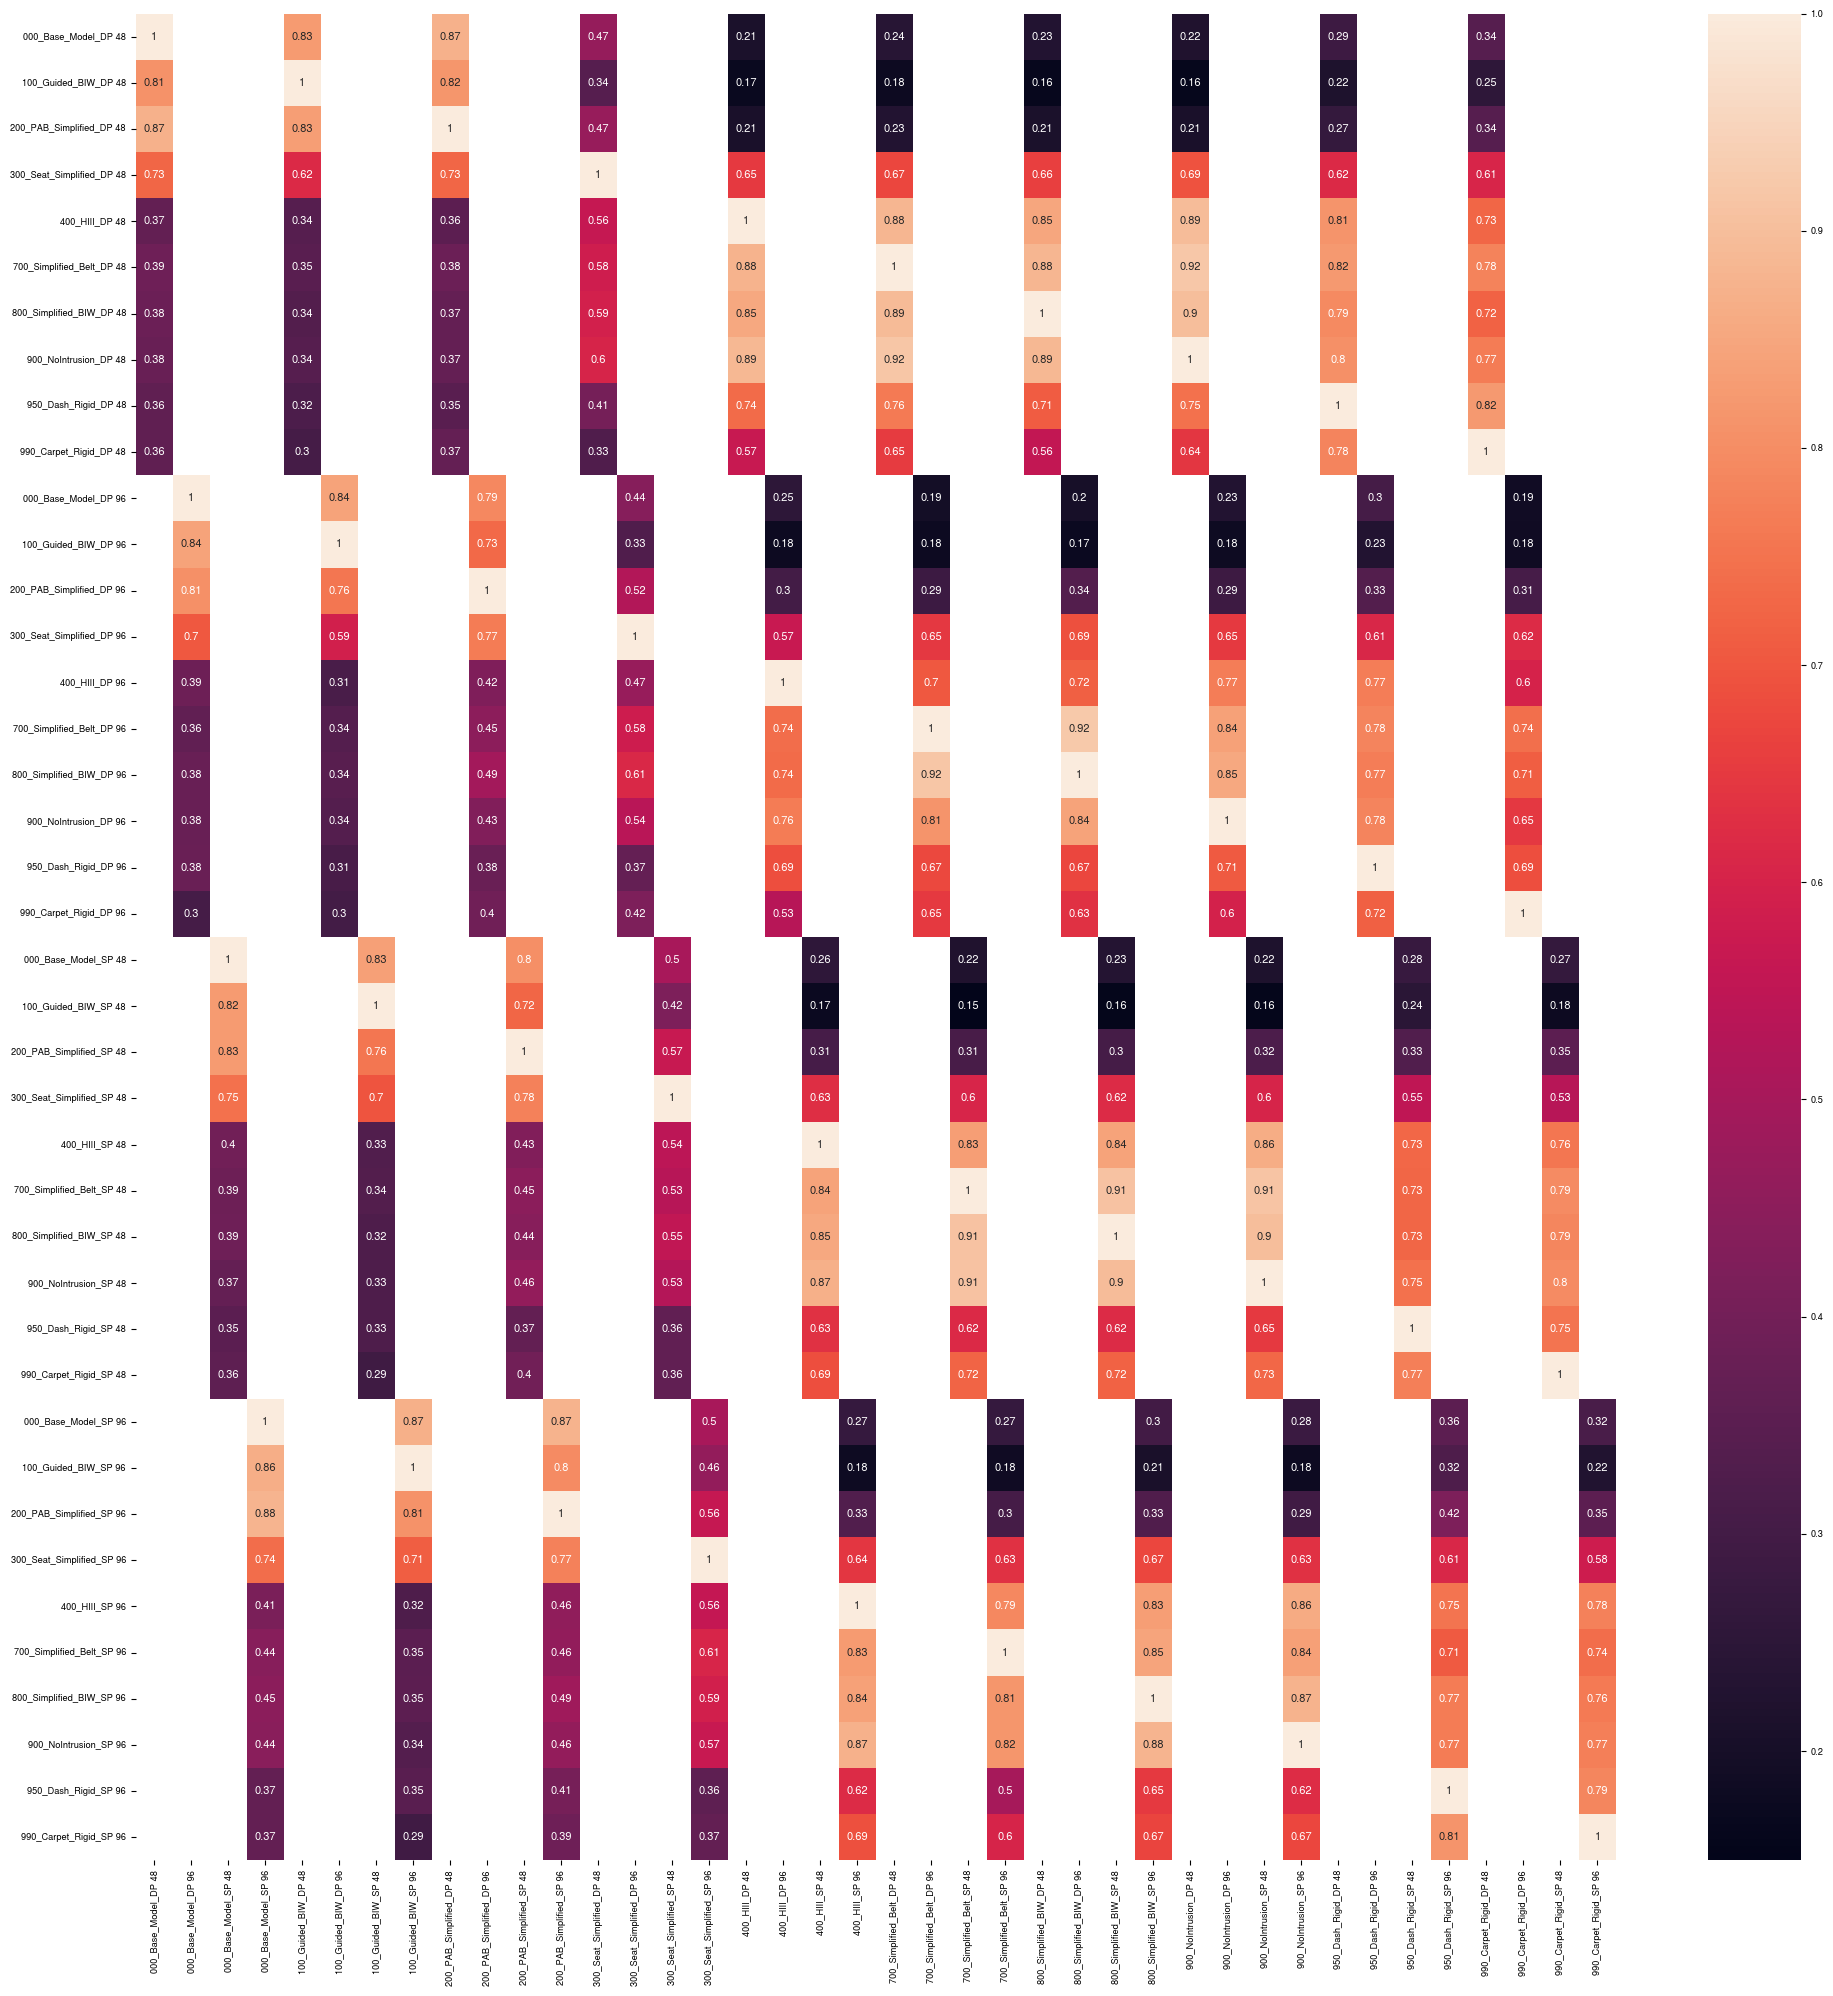

In [7]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(ISO_DATA["Full Frontal"]["03CHST0000??50ACZD"], ax=ax, annot=True)

In [8]:
def isolate(names: List[str]) -> Dict[str, List[str]]:
    groups = defaultdict(list)

    for name in names:
        if name.endswith("Report"):
            groups[name].append(name)
        else:
            groups[name[:-6]].append(name)

    return dict(groups)


def get_grouped_isos() -> Dict[str, Dict[str, pd.DataFrame]]:
    all_grouped_isos: Dict[str, Dict[str, pd.DataFrame]] = defaultdict(dict)

    for case in ISO_DATA.keys():
        for channel in ISO_DATA[case].keys():
            LOG.info("Processing %s %s", case, channel)
            db: pd.DataFrame = ISO_DATA[case][channel].copy()
            db.rename(
                columns={x: x.replace("_", " ").replace("CAE ", "") for x in db.columns if "Report" not in x},
                index={x: x.replace("_", " ").replace("CAE ", "") for x in db.index if "Report" not in x},
                inplace=True,
            )

            ref_groups = isolate(db.index)
            chal_groups = isolate(db.columns)

            iso_avgs = defaultdict(dict)
            for ref_group in ref_groups.keys():
                for chal_group in chal_groups.keys():
                    selection = db.loc[ref_groups[ref_group], chal_groups[chal_group]]
                    LOG.debug("Selection of %s to %s has shape %s", ref_group, chal_group, selection.shape)
                    iso_avgs[ref_group][chal_group] = selection.median(axis=None)
            all_grouped_isos[case][channel] = pd.DataFrame(iso_avgs)
            LOG.info("Grouped ISOs for %s %s with shape %s", case, channel, all_grouped_isos[case][channel].shape)

    return dict(all_grouped_isos)

ALL_GROUPED_ISOS = get_grouped_isos()

2024-09-16 10:26:38,194     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00ACXD
2024-09-16 10:26:38,321     INFO  MainProcess  MainThread Grouped ISOs for Full Frontal 00COG00000VH00ACXD with shape (12, 12)
2024-09-16 10:26:38,323     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00ACYD
2024-09-16 10:26:38,399     INFO  MainProcess  MainThread Grouped ISOs for Full Frontal 00COG00000VH00ACYD with shape (10, 10)
2024-09-16 10:26:38,400     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00VEXD
2024-09-16 10:26:38,501     INFO  MainProcess  MainThread Grouped ISOs for Full Frontal 00COG00000VH00VEXD with shape (12, 12)
2024-09-16 10:26:38,502     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00VEYD
2024-09-16 10:26:38,570     INFO  MainProcess  MainThread Grouped ISOs for Full Frontal 00COG00000VH00VEYD with shape (10, 10)
2024-09-16 10:26:38,572     INFO  MainProcess  MainThread Processing Full Frontal 03BELT

2024-09-16 10:26:46,061     INFO  MainProcess  MainThread Processing Full Frontal 03CHST0000??50ACZD


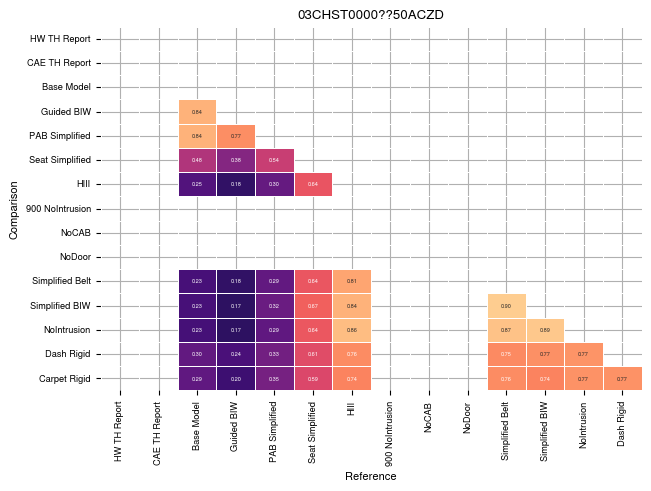

In [9]:
def show_isos(
    case: Literal["Full Frontal", "Oblique Left", "Oblique Right"],
    channels: Optional[List[str]] = None,
    ax: Optional[Axes] = None,
    cmap: Optional[str] = None,
    norm: Optional[str] = None,
) -> None:
    refs = ["HW TH Report", "CAE TH Report"] + [x.replace("_", " ") for x in CASES]
    chals = refs.copy()

    for channel in ALL_GROUPED_ISOS[case].keys() if channels is None else channels:
        LOG.info("Processing %s %s", case, channel)

        av_refs = set(ALL_GROUPED_ISOS[case][channel].columns)
        av_chals = set(ALL_GROUPED_ISOS[case][channel].index)

        selected = defaultdict(dict)
        for ref in refs:
            for chal in chals:
                if ref in av_refs and chal in av_chals:
                    if ref == chal:
                        selected[ref][chal] = np.nan
                    else:
                        selected[ref][chal] = ALL_GROUPED_ISOS[case][channel].loc[chal, ref]

                else:
                    selected[ref][chal] = np.nan
        to_plot = pd.DataFrame(selected, index=chals)
        to_plot.rename(
            index={idx: " ".join(idx.split()[1:]) for idx in to_plot.index if "Report" not in idx},
            columns={idx: " ".join(idx.split()[1:]) for idx in to_plot.columns if "Report" not in idx},
            inplace=True,
        )

        if ax is None:
            _, ax = plt.subplots(layout="constrained")
        sns.heatmap(
            to_plot[list(to_plot.index[:-1])],
            annot=True,
            mask=np.triu(np.ones_like(to_plot[list(to_plot.index[:-1])], dtype=bool), k=1),
            cbar=False,
            ax=ax,
            vmin=0,
            vmax=1,
            cmap="magma" if cmap is None else cmap,
            linewidth=0.7,
            norm=norm,
            fmt=".2f",
            # square=True,
            annot_kws={"fontsize":4}
        )
        ax.set_title(channel)
        ax.set_xlabel("Reference")
        ax.set_ylabel("Comparison")
        ax.grid()
        ax.set_axisbelow(True)
        # ax.invert_yaxis()

        # highlight upmid (TH Full Full vehicle vs H3 Buck)
        # for t in ax.texts:
        #    if t.get_position() == (1.5, 2.5) or t.get_position() == (0.5, 0.5) or t.get_position() == (0.5, 2.5):
        #        t.set_fontsize("large")
        #        t.set_fontweight("bold")


show_isos(LOAD_CASES[0], channels=["03CHST0000??50ACZD"])

2024-09-16 10:26:46,734     INFO  MainProcess  MainThread Processing load case Moderate Overlap Right with 4 channels
2024-09-16 10:26:46,815     INFO  MainProcess  MainThread Processing channel 00COG00000VH00VEXD
2024-09-16 10:26:46,816     INFO  MainProcess  MainThread Processing Moderate Overlap Right 00COG00000VH00VEXD
2024-09-16 10:26:47,275     INFO  MainProcess  MainThread Processing channel 00COG00000VH00VEYD
2024-09-16 10:26:47,276     INFO  MainProcess  MainThread Processing Moderate Overlap Right 00COG00000VH00VEYD
2024-09-16 10:26:47,838     INFO  MainProcess  MainThread Processing channel 00COG00000VH00ACXD
2024-09-16 10:26:47,839     INFO  MainProcess  MainThread Processing Moderate Overlap Right 00COG00000VH00ACXD
2024-09-16 10:26:48,422     INFO  MainProcess  MainThread Processing channel 00COG00000VH00ACYD
2024-09-16 10:26:48,423     INFO  MainProcess  MainThread Processing Moderate Overlap Right 00COG00000VH00ACYD


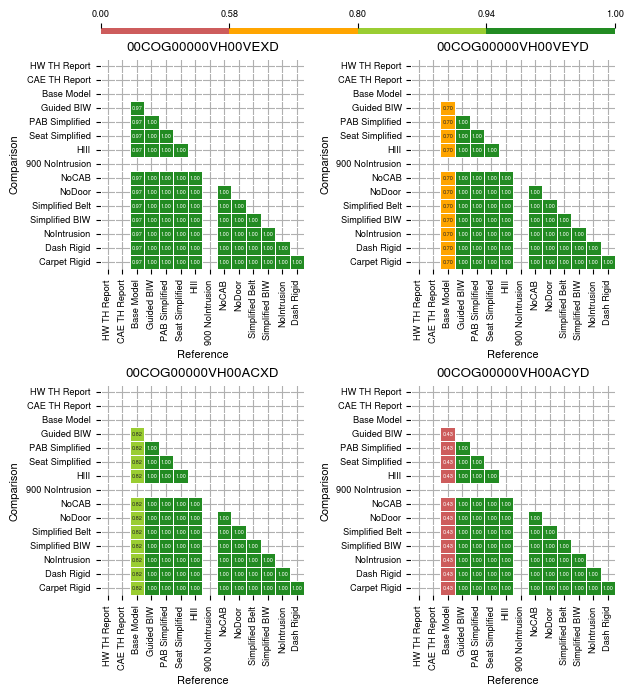

In [10]:
import matplotlib as mpl


def plot_channel_group(
    case: str,
    channels: List[List[str]],
    formats: Optional[List[str]] = None,
    grp_name: Optional[str] = None,
) -> None:
    LOG.info("Processing load case %s with %s channels", case, len(sum(channels, [])))

    fig_width: float = 1 * (448.13095 / 72)
    fig_height: float = 1.1 * fig_width
    fig, ax = plt.subplot_mosaic(
        [["none"] * len(channels[0]), *channels],
        figsize=(fig_width, 0.5 * len(channels) * fig_height),
        layout="constrained",
        gridspec_kw={"height_ratios": (0.025, *([1] * len(channels)))},
    )
    # fig.suptitle(f"{case} - ISO 18571 Rating")
    cmap = mpl.colors.ListedColormap(["indianred", "orange", "yellowgreen", "forestgreen"])
    bounds = [0, 0.58, 0.8, 0.94, 1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=ax["none"],
        location="top",
    )
    ax["none"].set(frame_on=False)
    ax["none"].set_xticklabels([f"{x:.2f}" for x in bounds])


    for ch in sum(channels, []):
        LOG.info("Processing channel %s", ch)
        show_isos(case=case, channels=[ch], ax=ax[ch], cmap=cmap, norm=norm)

    p_path = ISO_PATH / "Figures"
    p_path.mkdir(exist_ok=True, parents=True)
    if formats is not None:
        for fmt in formats:
            fp_path = p_path / fmt.upper()
            fp_path.mkdir(exist_ok=True)
            plt.savefig(fp_path / f"{case.replace(' ', '_')}_{grp_name}.{fmt}")
        plt.close(fig)


plot_channel_group(
    LOAD_CASES[2],
    [
        ["00COG00000VH00VEXD", "00COG00000VH00VEYD"],
        ["00COG00000VH00ACXD", "00COG00000VH00ACYD"],
    ],
)

In [11]:
# pulse
channel_sets = {
    "Pulses": [
        ["00COG00000VH00VEXD", "00COG00000VH00VEYD"],
        ["00COG00000VH00ACXD", "00COG00000VH00ACYD"],
    ]
}

# RHS
for s in ("03", ):
    # RHS
    channel_sets[f"{s}_RHS"] = [
        [f"{s}FAB00000VH00PRRD", f"{s}BELTBUSLVH00DSRD"],
        [f"{s}BELTB000VH00DSRD", f"{s}BELTB000VH00FORD"],
        [f"{s}BELTB300VH00FORD", f"{s}BELTB400VH00FORD"],
        [f"{s}BELTB500VH00FORD", f"{s}BELTB600VH00FORD"],
    ]

    # body
    for part in ("HEAD", "CHST", "PELV"):
        channel_sets[f"{s}_{part}"] = [
            [f"{s}{part}0000??50ACRD", f"{s}{part}0000??50ACXD"],
            [f"{s}{part}0000??50ACYD", f"{s}{part}0000??50ACZD"],
        ]

    # femur
    channel_sets[f"{s}_FMR"] = [
        [f"{s}FEMRLE00??50FORD", f"{s}FEMRRI00??50FORD"],
    ]

for case in LOAD_CASES:
    for channel_set in channel_sets.keys():
        plot_channel_group(case=case, channels=channel_sets[channel_set], formats=["png", "pdf"], grp_name=channel_set)

2024-09-16 10:26:51,739     INFO  MainProcess  MainThread Processing load case Full Frontal with 4 channels
2024-09-16 10:26:51,982     INFO  MainProcess  MainThread Processing channel 00COG00000VH00VEXD
2024-09-16 10:26:51,983     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00VEXD
2024-09-16 10:26:52,445     INFO  MainProcess  MainThread Processing channel 00COG00000VH00VEYD
2024-09-16 10:26:52,446     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00VEYD
2024-09-16 10:26:52,988     INFO  MainProcess  MainThread Processing channel 00COG00000VH00ACXD
2024-09-16 10:26:52,988     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00ACXD
2024-09-16 10:26:53,743     INFO  MainProcess  MainThread Processing channel 00COG00000VH00ACYD
2024-09-16 10:26:53,744     INFO  MainProcess  MainThread Processing Full Frontal 00COG00000VH00ACYD
2024-09-16 10:26:58,312     INFO  MainProcess  MainThread maxp pruned
2024-09-16 10:26:58,318     INFO  

In [12]:
ALL_GROUPED_ISOS.keys()

dict_keys(['Full Frontal', 'Moderate Overlap Left', 'Moderate Overlap Right', 'Oblique Left', 'Oblique Right'])